In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from tensorflow import keras
import tensorflow as tf
import keras.models as models
import keras.layers as layers
import keras.initializers as initializers
import keras.optimizers as optimizers
import keras.regularizers as regularizers
import keras.metrics as metrics
import keras.callbacks as callbacks
import keras.losses as losses
import joblib
import warnings
import Customs.CustomLayers as CLayers
import Customs.EvaluationFunctions as eval_funcs
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
warnings.filterwarnings("ignore")
rs = 7

tf.random.set_seed(rs)
np.random.seed(rs)
random.seed(rs)

In [2]:
data = joblib.load("Storage/Input Data")

In [3]:
train, val, test = data

In [4]:
X_train, y_train = train
X_val, y_val = val
X_test, y_test = test
X_train.shape, y_train.shape

((4007, 48, 10), (4007, 1))

In [5]:
#Setting hyperparameters

input_shape = X_train[0].shape

kernel_init = initializers.LecunUniform(seed=rs)
bias_init = initializers.Zeros()

batch_size = 512
lr = 7e-4

optimizer = keras.optimizers.Adam(learning_rate = lr)

metrics_list = [metrics.RootMeanSquaredError(name="rmse"), "mae", metrics.MeanSquaredLogarithmicError(name="msle")]

loss = losses.Huber()

callback_list = []


### Creating Networks

In [6]:
def LSTMModel(architecture: list):

    inputs = layers.Input(shape=X_train[0].shape)

    x = inputs
    
    for unit in architecture[:-1]:
        x = layers.LSTM(unit, return_sequences=True,
                    activation="tanh", kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    
    x = layers.LSTM(architecture[-1], return_sequences=False,
                    activation="tanh", kernel_initializer=kernel_init, bias_initializer=bias_init)(x)

    outputs = layers.Dense(1, activation="linear", kernel_initializer=kernel_init, bias_initializer=bias_init)(x)

    lstm_model = models.Model(inputs, outputs)
    lstm_model.compile(loss=loss, optimizer=optimizer, metrics=metrics_list)

    lstm_model.summary()

    return lstm_model

In [7]:
def BiLSTMModel(units: int, conv_parameters: list, add_t2vec=False, attention_dim = None):

    inputs = layers.Input(shape=X_train[0].shape)

    x = inputs

    if add_t2vec:

        t = CLayers.Time2Vector(seq_len = X_train[0].shape[-2], 
                        kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
        
        x = layers.Concatenate(axis=-1)([x, t])

    if conv_parameters is not None:

        assert len(conv_parameters) == 4, "Conv Parameters: [filters, kernel_size, strides, padding]"

        filters = conv_parameters[0]
        kernel_size = conv_parameters[1]
        strides = conv_parameters[2]
        padding= conv_parameters[3]

        x = layers.Conv1D(filters, kernel_size, strides, padding, activation="relu",
                            kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
        
    if attention_dim is not None:
        x = layers.Bidirectional(layers.LSTM(units, return_sequences=True,
                    activation="tanh", kernel_initializer=kernel_init, bias_initializer=bias_init))(x)
        x = CLayers.AttentionLayer(attention_dim)(x)
    else:
        x = layers.Bidirectional(layers.LSTM(units, return_sequences=False,
                    activation="tanh", kernel_initializer=kernel_init, bias_initializer=bias_init))(x)

    outputs = layers.Dense(1, activation="linear", kernel_initializer=kernel_init, bias_initializer=bias_init)(x)

    bilstm_model = models.Model(inputs, outputs)
    bilstm_model.compile(loss=loss, optimizer=optimizer, metrics=metrics_list)

    bilstm_model.summary()

    return bilstm_model

In [8]:
lstm = LSTMModel(architecture=[64])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 10)]          0         
                                                                 
 lstm (LSTM)                 (None, 64)                19200     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 19,265
Trainable params: 19,265
Non-trainable params: 0
_________________________________________________________________


In [9]:
stacked_lstm = LSTMModel(architecture=[32,32])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 10)]          0         
                                                                 
 lstm_1 (LSTM)               (None, 48, 32)            5504      
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 13,857
Trainable params: 13,857
Non-trainable params: 0
_________________________________________________________________


In [10]:
bilstm = BiLSTMModel(units=32, conv_parameters=None, add_t2vec=False, attention_dim=None)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 48, 10)]          0         
                                                                 
 bidirectional (Bidirectiona  (None, 64)               11008     
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 11,073
Trainable params: 11,073
Non-trainable params: 0
_________________________________________________________________


In [11]:
conv_bilstm = BiLSTMModel(units=32, conv_parameters=[16,5,1,"causal"], add_t2vec=False, attention_dim=None)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 48, 10)]          0         
                                                                 
 conv1d (Conv1D)             (None, 48, 16)            816       
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               12544     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 13,425
Trainable params: 13,425
Non-trainable params: 0
_________________________________________________________________


In [12]:
t_conv_bilstm = BiLSTMModel(units=32, conv_parameters=[16,5,1,"causal"], add_t2vec=True, attention_dim=None)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 48, 10)]     0           []                               
                                                                                                  
 time2_vector (Time2Vector)     (None, 48, 2)        192         ['input_5[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 48, 12)       0           ['input_5[0][0]',                
                                                                  'time2_vector[0][0]']           
                                                                                                  
 conv1d_1 (Conv1D)              (None, 48, 16)       976         ['concatenate[0][0]']      

In [13]:
t_conv_bilstm_att = BiLSTMModel(units=32, conv_parameters=[16,5,1,"causal"], add_t2vec=True, attention_dim=32)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 48, 10)]     0           []                               
                                                                                                  
 time2_vector_1 (Time2Vector)   (None, 48, 2)        192         ['input_6[0][0]']                
                                                                                                  
 concatenate_1 (Concatenate)    (None, 48, 12)       0           ['input_6[0][0]',                
                                                                  'time2_vector_1[0][0]']         
                                                                                                  
 conv1d_2 (Conv1D)              (None, 48, 16)       976         ['concatenate_1[0][0]']    

In [14]:
model_dict = {"LSTM": lstm,
              "Stacked LSTM": stacked_lstm,
              "BiLSTM": bilstm,
              "ConvBiLSTM": conv_bilstm,
              "ConvBiLSTM+T": t_conv_bilstm,
              "ConvBiLSTM+T+ATT": t_conv_bilstm_att}

### Training and Results Comparison

Training LSTM...
Training Stacked LSTM...
Training BiLSTM...
Training ConvBiLSTM...
Training ConvBiLSTM+T...
Training ConvBiLSTM+T+ATT...


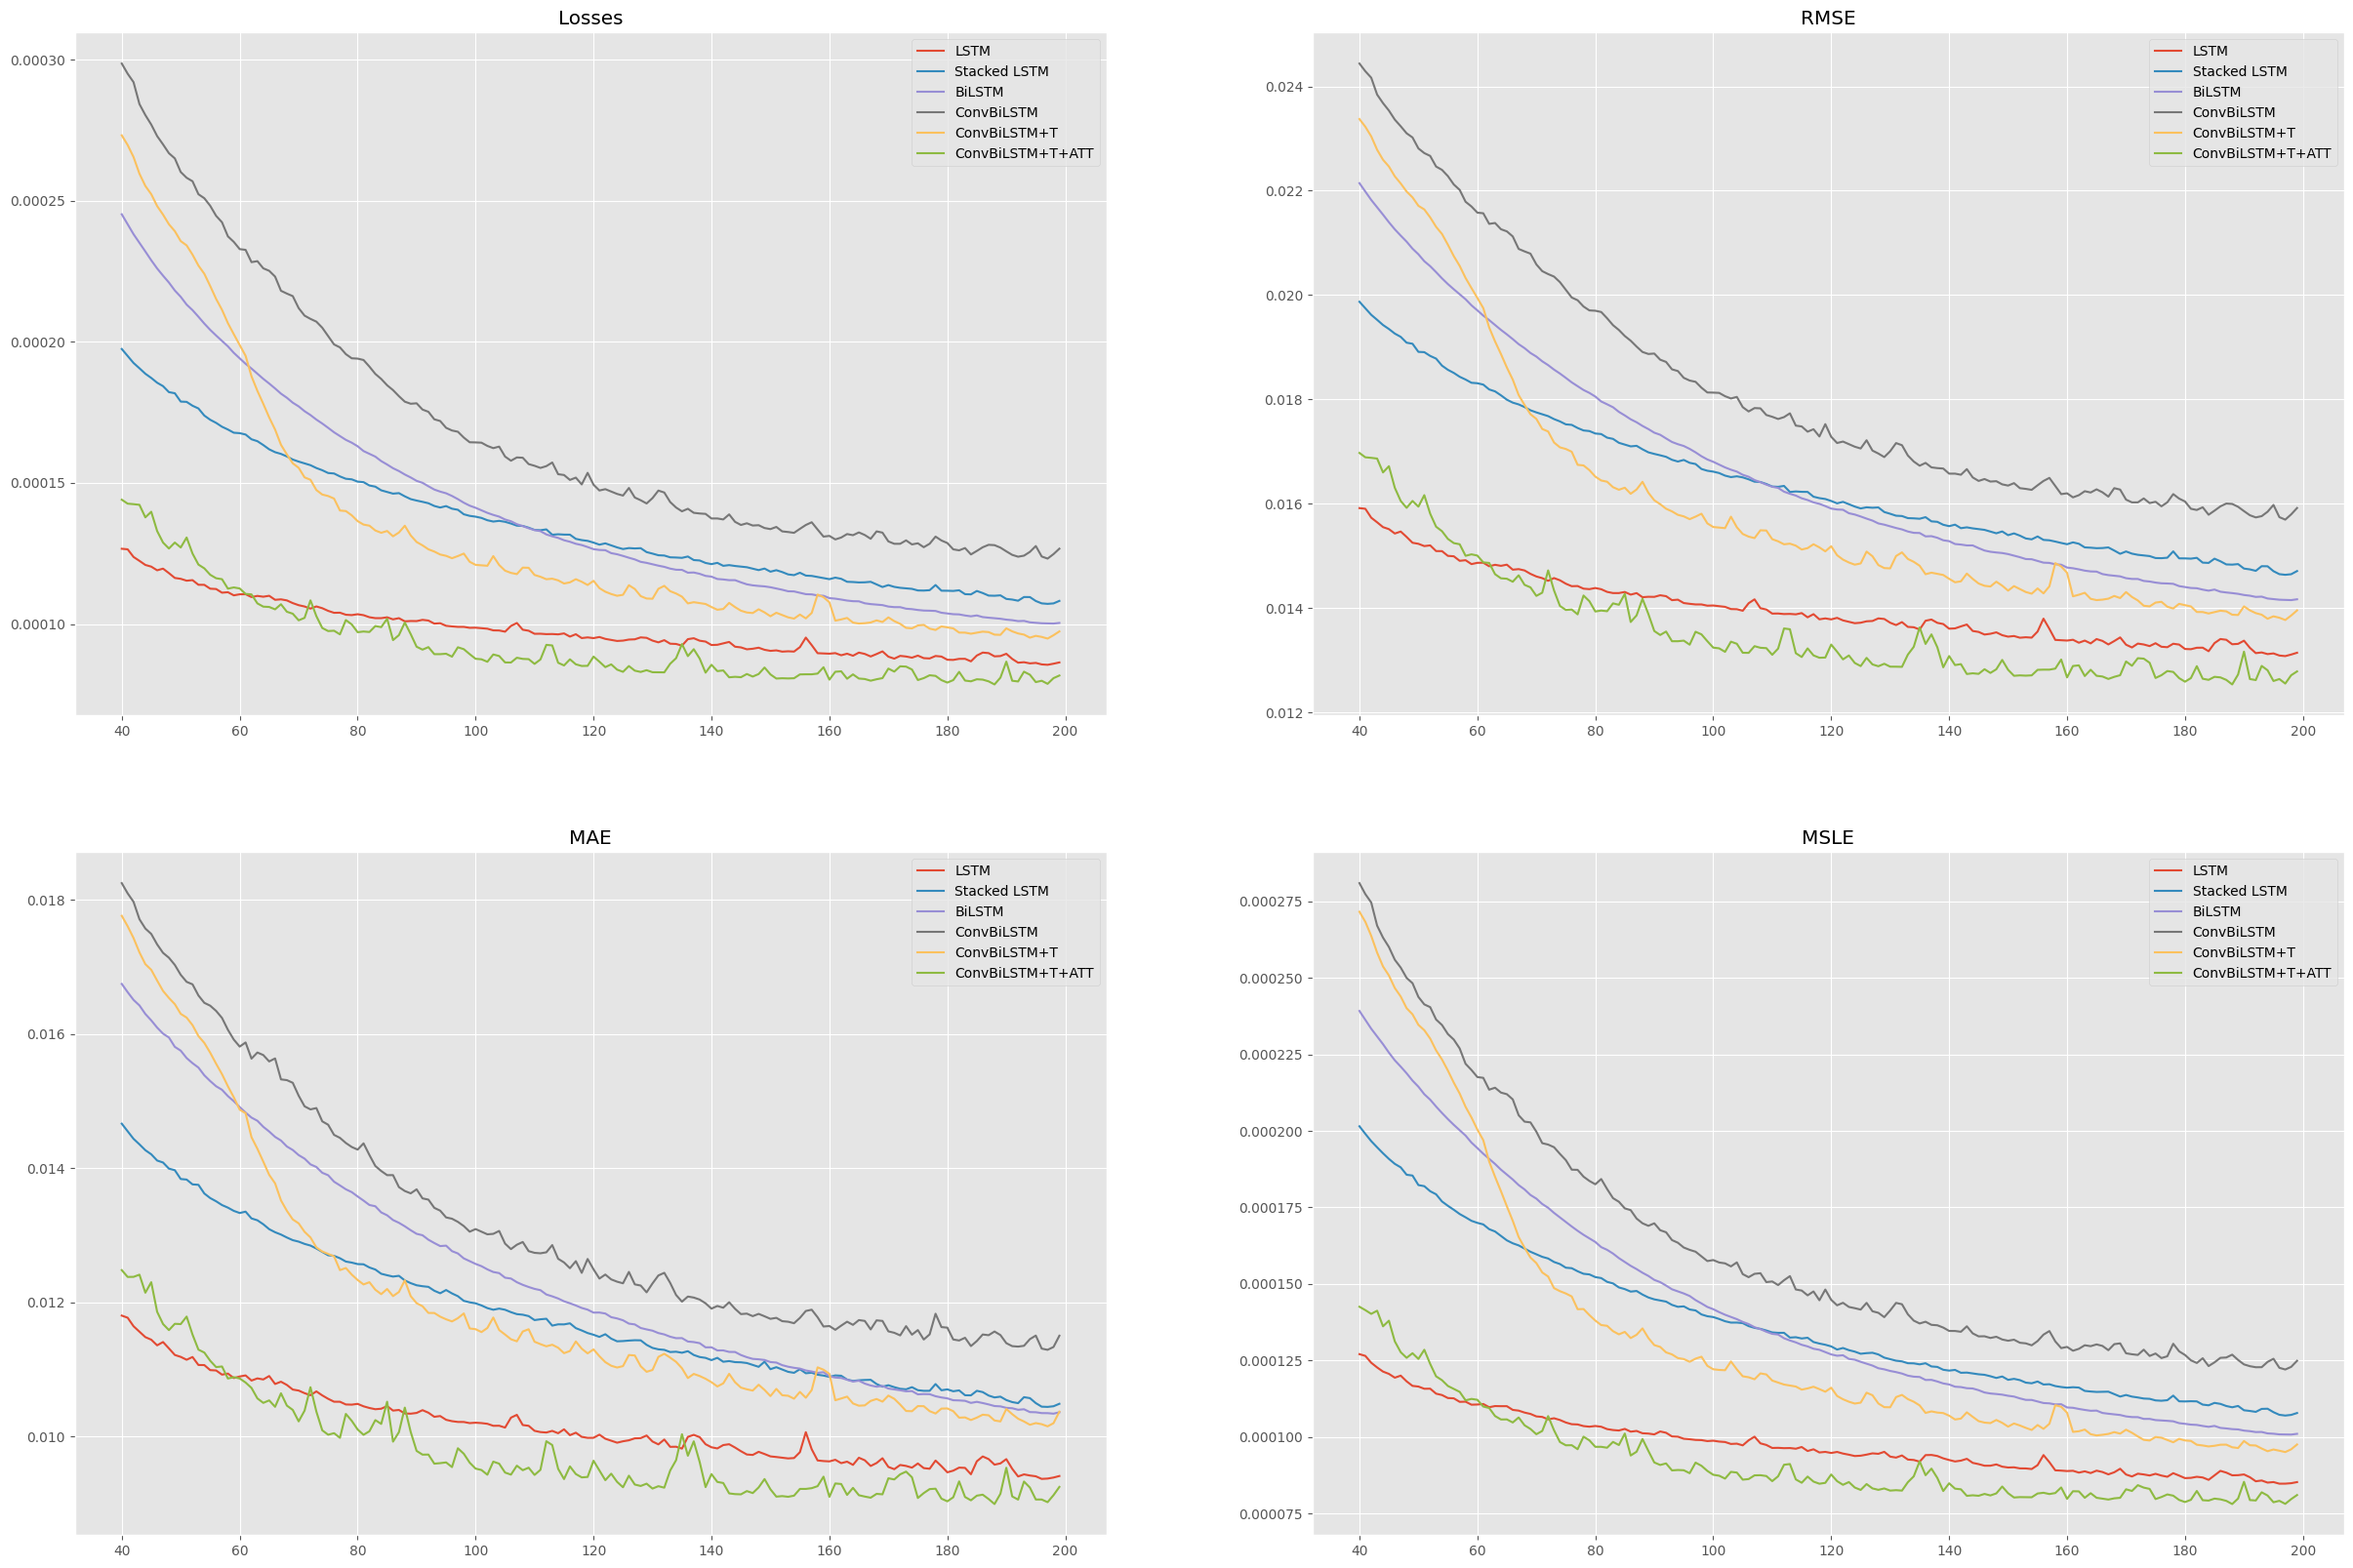

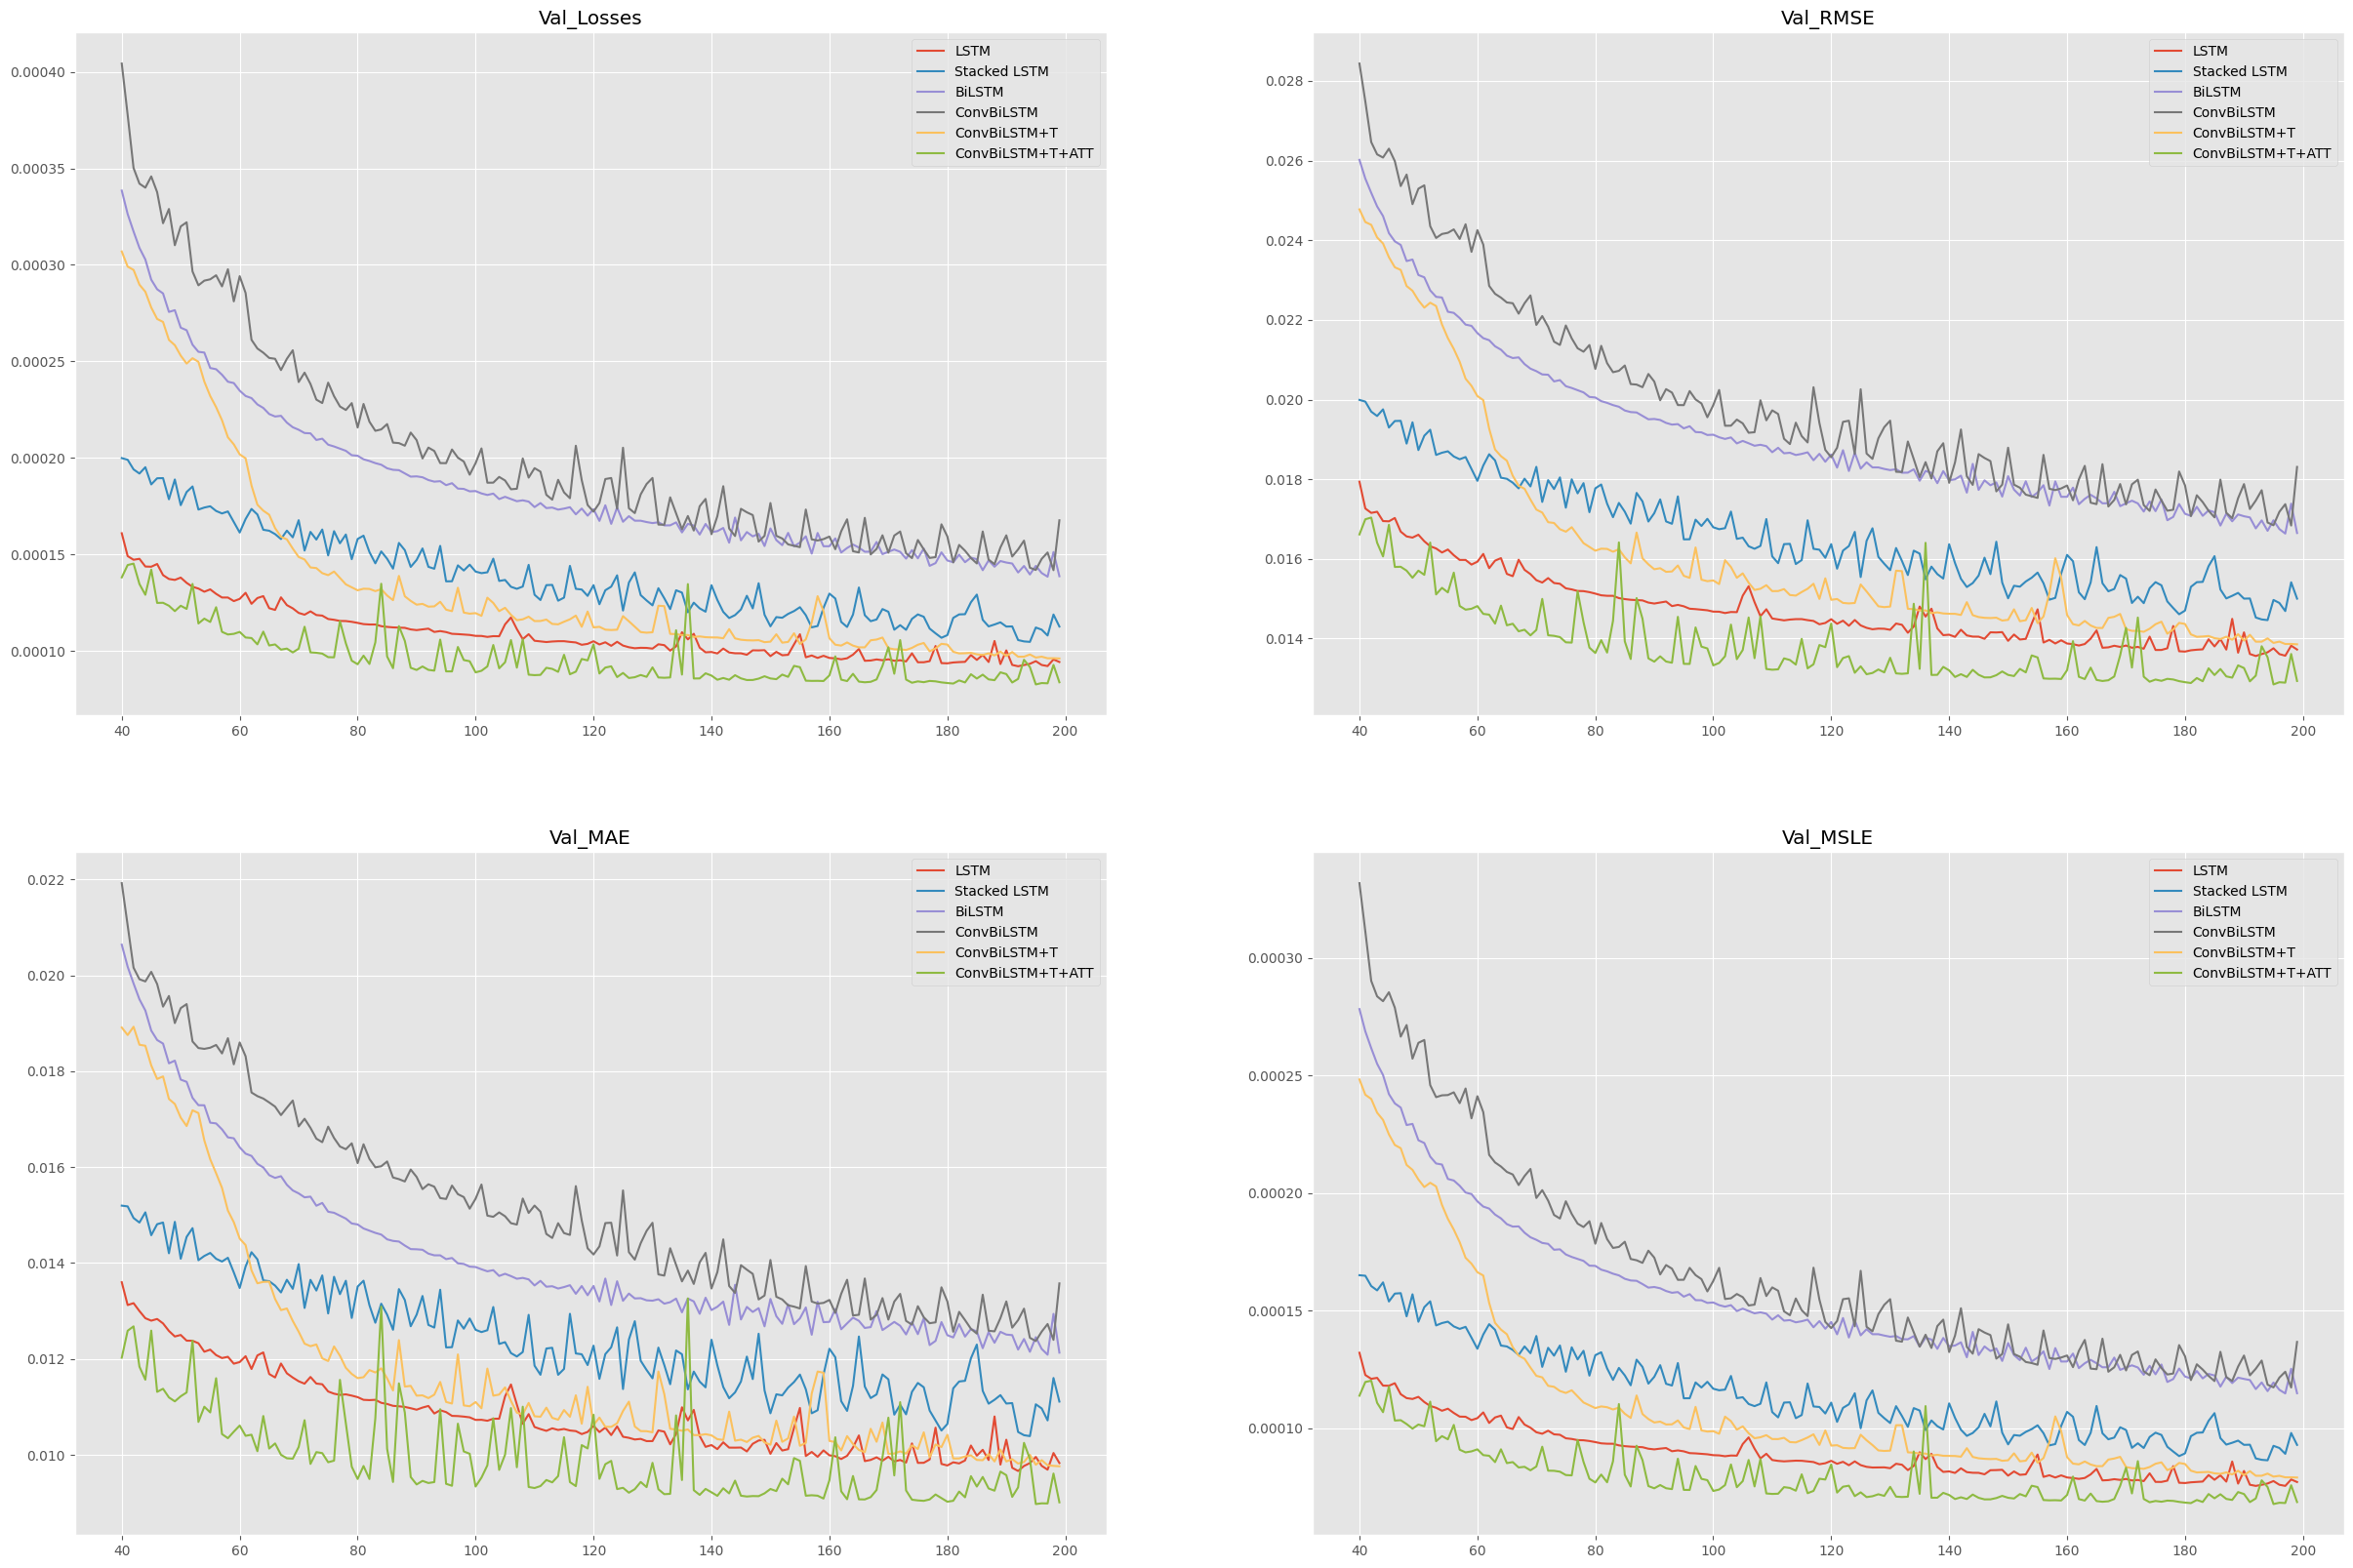

In [15]:
#we'll train for 200 epochs due to very large batch size relative to the amount of data
results = eval_funcs.training(train_data=train, val_data=val, models=model_dict, epochs=200, batch_size=batch_size, callbacks=callback_list, plot=True)

In [16]:
eval_matrix = eval_funcs.evaluation(results_dict=results)

In [17]:
eval_matrix

,Losses,Val_Losses,RMSE,Val_RMSE,MAE,Val_MAE,MSLE,Val_MSLE
LSTM,0.000086,0.000094,0.013144,0.013726,0.009415,0.009830,0.000085,0.000077
Stacked LSTM,0.000108,0.000113,0.014709,0.015004,0.010491,0.011111,0.000108,0.000093
BiLSTM,0.000100,0.000139,0.014168,0.016651,0.010364,0.012132,0.000101,0.000115
ConvBiLSTM,0.000127,0.000168,0.015918,0.018310,0.011505,0.013576,0.000125,0.000137
ConvBiLSTM+T,0.000097,0.000096,0.013955,0.013857,0.010373,0.009762,0.000098,0.000079
ConvBiLSTM+T+ATT,0.000082,0.000084,0.012786,0.012937,0.009253,0.009010,0.000081,0.000068


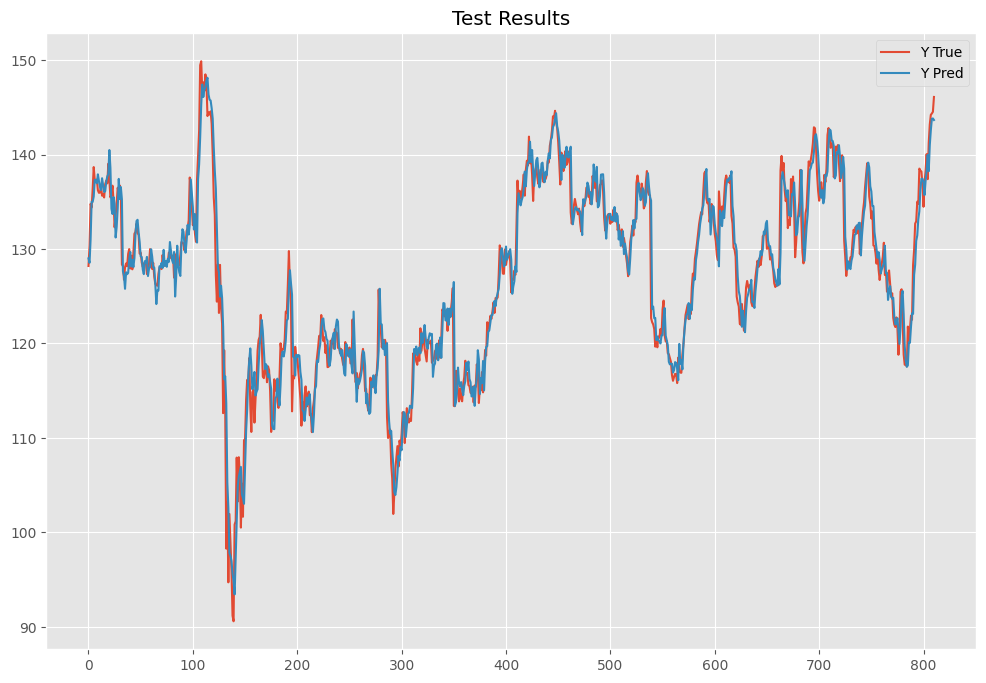

In [18]:
best_model = model_dict["ConvBiLSTM+T+ATT"] #best performing model with 0.0129 rmse on validation data

y_pred = best_model.predict(X_test, verbose=0)
pred_df = eval_funcs.plot_preds(true_vals=y_test, preds=y_pred, title="Test Results")

In [19]:
RMSE = mse(pred_df["Y True"], pred_df["Y Pred"])**(0.5)
MAE = mae(pred_df["Y True"], pred_df["Y Pred"])

print("Performance on Test Data:")
print(f"MAE: {MAE:.2f}, RMSE: {RMSE:.2f}")

Performance on Test Data:
MAE: 1.65, RMSE: 2.36
